In [1]:
from numpy import *
from matplotlib.pyplot import *
import numpy.fft as fft
import scipy.optimize as opt
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
from JSAnimation import IPython_display
from scipy.constants import physical_constants
import time
import os
%matplotlib inline

In [2]:
hbar = physical_constants["Planck constant over 2 pi"][0]
a0 = physical_constants['Bohr radius'][0]
m6Li2 = 2*9.98834e-27
mRb87 = 1.443160e-25
aRb87 = 100*a0

def kappa(omega, a_s, N, m):
    x_s = sqrt(hbar/(omega*m))
    return 4*pi*N*a_s/x_s

def healing_length(omega, a_s, N, m):
    x_s = sqrt(hbar/(omega*m))
    return sqrt(x_s**3/(8*pi*abs(a_s)*N))

def dist_dim_to_adim(x_dim, omega, m):
    x_s = sqrt(hbar/(omega*m))
    return x_dim/x_s

def time_dim_to_adim(t_dim, omega, m):
    return t_dim*omega

def psi_dim_to_adim(psi_dim, omega, m):
    x_s = sqrt(hbar/(omega*m))
    return psi_dim*sqrt(x_s)**3

def psi_adim_to_dim(psi_adim, omega, m):
    x_s = sqrt(hbar/(omega*m))
    return psi_adim/sqrt(x_s)**3

def psi_error(psi_analytic, psi_numeric, dx_, dy_, dz_):
    return normalization(psi_analytic-psi_numeric, dx_, dy_, dz_)

def normalization(psi, dx_, dy_, dz_):
    return sum(conjugate(psi)*psi)*dx_*dy_*dz_

def harmonic_potencial_adim(X, Y, Z, t, dt, args=[]):
    nu, eta, zeta = args
    return 0.5*dt*((nu*X)**2 + (eta*Y)**2 + (zeta*Z)**2)

def TSSP_step(psi0, t, x, y, z, U_pot, kappa, imag_time, dt, pot_args):
    if imag_time:
        alpha = 1.0j
    else:
        alpha = 1.0

    X, Y, Z = meshgrid(x, y, z)

    kx = fft.fftfreq(size(x),x[1]-x[0])*2.0*pi
    ky = fft.fftfreq(size(y),y[1]-y[0])*2.0*pi
    kz = fft.fftfreq(size(z),z[1]-z[0])*2.0*pi
    Kx, Ky, Kz = meshgrid(kx, ky, kz)

    U_int  = U_pot(X, Y, Z, t, dt, pot_args)
    
    psi = psi0
    psi = exp(0.5*(-1.0j/alpha)*(U_int+dt*kappa*psi*conj(psi)))*psi
    psi = fft.ifft(exp((-1.0j/alpha)*dt*Ky**2/2.0)*fft.fft(psi, axis=0), axis=0)
    psi = fft.ifft(exp((-1.0j/alpha)*dt*Kx**2/2.0)*fft.fft(psi, axis=1), axis=1)
    psi = fft.ifft(exp((-1.0j/alpha)*dt*Kz**2/2.0)*fft.fft(psi, axis=2), axis=2)
    psi = exp(0.5*(-1.0j/alpha)*(U_int+dt*kappa*psi*conj(psi)))*psi
    
    if imag_time:
        psi = psi/sqrt(normalization(psi,x[1]-x[0], y[1]-y[0], z[1]-z[0]))
        
    return psi

def Thomas_Fermi(X, Y, Z, t, N, omega, a_s, m):
    omega_bar = (omega[0]*omega[1]*omega[2])**(1./3.)
    x_s=sqrt(hbar/(m*omega_bar))
    mu=0.5*hbar*omega_bar*(15*N*a_s/x_s)**(2./5.)
    rTF=sqrt(2*mu/(m*omega**2))
    print rTF
    n_=(m/(4*pi*hbar**2*N*a_s))* mu*maximum(1-(X/rTF[0])**2-(Y/rTF[1])**2-(Z/rTF[2])**2,0)
    return sqrt(n_)*exp(-1j*mu*t/hbar)

def gaussian(x, A, sigma0, x0):
    return A*exp(-0.5*((x-x0)/sigma0)**2)

In [3]:
def column_density_plot(psi, x, y, z, aspect_ratio='equal', interp="none"):
    fig = figure(figsize=(14, 14))
    ax = fig.subplots(ncols=3, nrows=3)
    
    im0 = ax[0,0].imshow(sum(real(psi), axis=0), 
                         extent=1e6*array([z[0],z[-1],x[-1],x[0]]), aspect=aspect_ratio, interpolation=interp)
    divider = make_axes_locatable(ax[0,0])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    colorbar(im0, cax=cax, orientation='vertical')
    ax[0,0].set_xlabel(r"$z\ [\mu m]$", fontsize=15)
    ax[0,0].set_ylabel(r"$x\ [\mu m]$", fontsize=15)
    
    
    im1 = ax[0,1].imshow(sum(real(psi), axis=1), 
                         extent=1e6*array([z[0],z[-1],y[-1],y[0]]), aspect=aspect_ratio, interpolation=interp)
    divider = make_axes_locatable(ax[0,1])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    colorbar(im1, cax=cax, orientation='vertical')
    ax[0,1].set_xlabel(r"$z\ [\mu m]$", fontsize=15)
    ax[0,1].set_ylabel(r"$y\ [\mu m]$", fontsize=15)
    
    im2 = ax[0,2].imshow(sum(real(psi), axis=2), 
                         extent=1e6*array([x[0],x[-1],y[-1],y[0]]), aspect=aspect_ratio, interpolation=interp)
    divider = make_axes_locatable(ax[0,2])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    colorbar(im2, cax=cax, orientation='vertical')
    ax[0,2].set_xlabel(r"$x\ [\mu m]$", fontsize=15)
    ax[0,2].set_ylabel(r"$y\ [\mu m]$", fontsize=15)
    
    im0 = ax[1,0].imshow(sum(imag(psi), axis=0), 
                         extent=1e6*array([z[0],z[-1],x[-1],x[0]]), aspect=aspect_ratio, interpolation=interp)
    divider = make_axes_locatable(ax[1,0])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    colorbar(im0, cax=cax, orientation='vertical')
    ax[1,0].set_xlabel(r"$z\ [\mu m]$", fontsize=15)
    ax[1,0].set_ylabel(r"$x\ [\mu m]$", fontsize=15)
    
    im1 = ax[1,1].imshow(sum(imag(psi), axis=1), 
                         extent=1e6*array([z[0],z[-1],y[-1],y[0]]), aspect=aspect_ratio, interpolation=interp)
    divider = make_axes_locatable(ax[1,1])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    colorbar(im1, cax=cax, orientation='vertical')
    ax[1,1].set_xlabel(r"$z\ [\mu m]$", fontsize=15)
    ax[1,1].set_ylabel(r"$y\ [\mu m]$", fontsize=15)
    
    im2 = ax[1,2].imshow(sum(imag(psi), axis=2), 
                         extent=1e6*array([x[0],x[-1],y[-1],y[0]]), aspect=aspect_ratio, interpolation=interp)
    divider = make_axes_locatable(ax[1,2])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    colorbar(im2, cax=cax, orientation='vertical')
    ax[1,2].set_xlabel(r"$x\ [\mu m]$", fontsize=15)
    ax[1,2].set_ylabel(r"$y\ [\mu m]$", fontsize=15)
    
    im0 = ax[2,0].imshow(sum(abs(psi)**2, axis=0), 
                         extent=1e6*array([z[0],z[-1],x[-1],x[0]]), aspect=aspect_ratio, interpolation=interp)
    divider = make_axes_locatable(ax[2,0])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    colorbar(im0, cax=cax, orientation='vertical')
    ax[2,0].set_xlabel(r"$z\ [\mu m]$", fontsize=15)
    ax[2,0].set_ylabel(r"$x\ [\mu m]$", fontsize=15)
    
    im1 = ax[2,1].imshow(sum(abs(psi)**2, axis=1), 
                         extent=1e6*array([z[0],z[-1],y[-1],y[0]]), aspect=aspect_ratio, interpolation=interp)
    divider = make_axes_locatable(ax[2,1])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    colorbar(im1, cax=cax, orientation='vertical')
    ax[2,1].set_xlabel(r"$z\ [\mu m]$", fontsize=15)
    ax[2,1].set_ylabel(r"$y\ [\mu m]$", fontsize=15)
    
    im2 = ax[2,2].imshow(sum(abs(psi)**2, axis=2), 
                         extent=1e6*array([x[0],x[-1],y[-1],y[0]]), aspect=aspect_ratio, interpolation=interp)
    divider = make_axes_locatable(ax[2,2])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    colorbar(im2, cax=cax, orientation='vertical')
    ax[2,2].set_xlabel(r"$x\ [\mu m]$", fontsize=15)
    ax[2,2].set_ylabel(r"$y\ [\mu m]$", fontsize=15)
    
    tight_layout()

# Modulación del confinamiento radial

def harmonic_w_rad_modulation(X, Y, Z, t, dt, args=[]):
    nu, eta, zeta, eps, W = args
    t1 = 2*dt*(2*(zeta*Z)**2+((nu*X)**2+(eta*Y)**2)*(2+eps**2))*W
    t2 = ((nu*X)**2+(eta*Y)**2)*eps
    t3 = 8*cos(W*t)-8*cos(W*(t+dt))
    t4 = eps*(sin(2*W*t)-sin(2*W*(t+dt)))
    return (t1+t2*(t3+t4))/(8*W)

### Parámetros

In [4]:
N = 6e3
x_max = 20e-6
y_max = 20e-6
z_max = 150e-6
h = 0.2e-6
dx_real = h
dy_real = h
dz_real = 3*h
print "dr = ", dx_real
print "dz = ", dz_real

tau = 20e-6
t_max = 50e-3
w_x = 2*pi*163.0
w_y = 2*pi*163.0
w_z = 2*pi*11
w_bar = (w_x*w_y*w_z)**(1./3.)
a_scat = 0.6*1443.1*a0
m_num = m6Li2

n_per_step = 10

g_kap = kappa(omega=w_bar, a_s=a_scat, N=N, m=m_num)
x_real = arange(-x_max, x_max, dx_real)
y_real = arange(-y_max, y_max, dy_real)
z_real = arange(-z_max, z_max, dz_real)
t_real = arange(0, t_max, tau)
psi0_real = ones((len(y_real), len(x_real), len(z_real)))

x_adim  = dist_dim_to_adim(x_real,  omega=w_bar, m=m_num)
y_adim  = dist_dim_to_adim(y_real,  omega=w_bar, m=m_num)
z_adim  = dist_dim_to_adim(z_real,  omega=w_bar, m=m_num)
dx_adim = dist_dim_to_adim(dx_real, omega=w_bar, m=m_num)
dy_adim = dist_dim_to_adim(dy_real, omega=w_bar, m=m_num)
dz_adim = dist_dim_to_adim(dz_real, omega=w_bar, m=m_num)
t_adim  = time_dim_to_adim(t_real,  omega=w_bar, m=m_num)
dt_adim = time_dim_to_adim(tau,     omega=w_bar, m=m_num)

psi_adim = psi_dim_to_adim(psi0_real, omega=w_bar, m=m_num)
psi_adim = psi_adim/sqrt(normalization(psi_adim, dx_adim, dy_adim, dz_adim))
print g_kap
print dt_adim
print len(x_real), len(y_real), len(z_real), len(x_real)*len(y_real)*len(z_real)
print len(t_adim)

dr =  2e-07
dz =  6e-07
970.922920593356
0.00833935564381
201 201 500 20200500
2500


## Estado base Thomas Fermi

[5.93982196e-06 5.93982196e-06 8.80173617e-05]


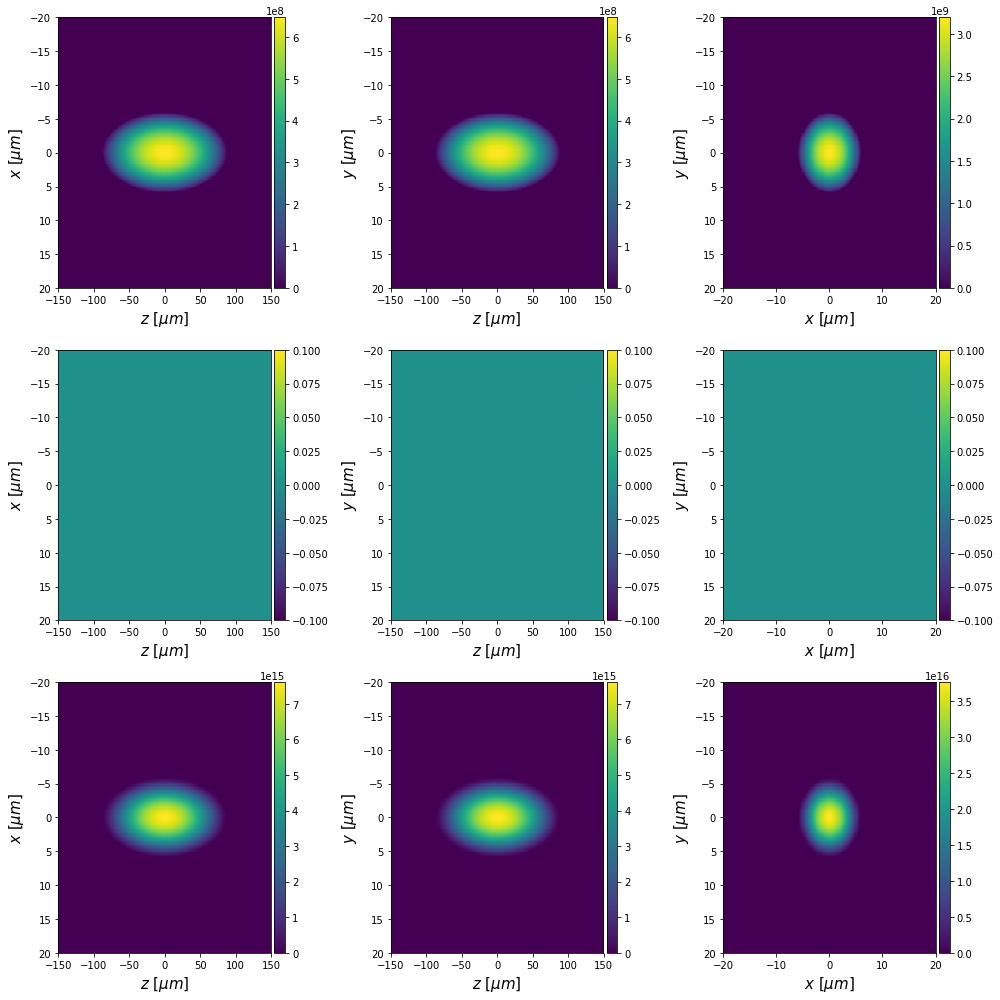

In [5]:
X, Y, Z = meshgrid(x_real, y_real, z_real)
psi_harmonic_oscilator_interactions = Thomas_Fermi(X, Y, Z, 0, N, array([w_x,w_y,w_z]), a_scat, m_num)
column_density_plot(psi=psi_harmonic_oscilator_interactions, x=x_real, y=y_real, z=z_real,
                   aspect_ratio="auto", interp="none")

## Estado base

In [6]:
start_time = time.time()
psi_step_temp = psi_adim
eps = 1
count = 0
while eps>1e-5:
    count += 1
    psi_step = TSSP_step(psi_step_temp, 0, x_adim, y_adim, z_adim, harmonic_potencial_adim, g_kap, True, dt_adim, 
                         array([w_x/w_bar, w_y/w_bar, w_z/w_bar]))
    eps = abs(psi_error(psi_step, psi_step_temp, dx_adim, dy_adim, dz_adim))
    psi_step_temp = psi_step
    
    print count, eps
    
ground_state_trap_mod_adim = psi_step
ground_state_trap_mod_dim  = psi_adim_to_dim(ground_state_trap_mod_adim, w_bar, m_num)
print("--- %s seconds ---" % (time.time() - start_time))

1 0.09605248385122156
2 0.05951994766503567
3 0.03494652393969745
4 0.021282086005796265
5 0.013855998580766212
6 0.009605258249011891
7 0.006987483982710328
8 0.005261706086443044
9 0.004060331756408442
10 0.003189233397907619
11 0.0025384706766696198
12 0.00204152867998373
13 0.001655778993001762
14 0.0013525592050448365
15 0.0011118350314383242
16 0.0009191658383458622
17 0.0007638897602245515
18 0.0006379868340478639
19 0.0005353366062492595
20 0.00045121524457275336
21 0.00038194401005003
22 0.0003246370134586158
23 0.0002770163347746605
24 0.0002372742212546426
25 0.0002039690211426077
26 0.00017594578961781636
27 0.0001522752322591991
28 0.00013220644974141786
29 0.00011513017048313681
30 0.00010055001326479209
31 8.805993435406037e-05
32 7.732646085507194e-05
33 6.807464340206714e-05
34 6.007690974271052e-05
35 5.3144188580859734e-05
36 4.7118815975000206e-05
37 4.186884588869083e-05
38 3.7283470403543634e-05
39 3.326931974081505e-05
40 2.9747462167398585e-05
41 2.6650962534720

ground_state_trap_mod_dim = load("ground_state_trap_mod_dim.npy")
ground_state_trap_mod_adim = psi_dim_to_adim(psi_dim=ground_state_trap_mod_dim, omega=w_bar, m=m_num)

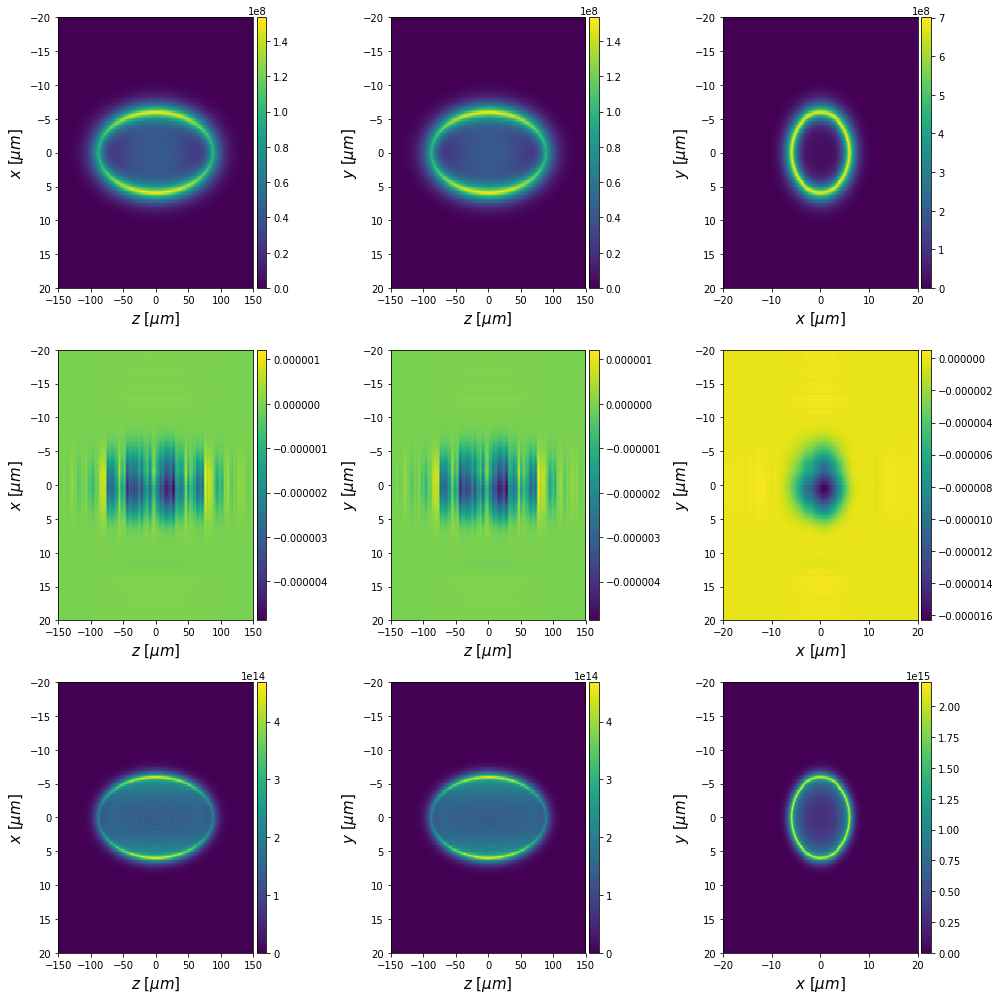

In [7]:
column_density_plot(psi=ground_state_trap_mod_dim-psi_harmonic_oscilator_interactions, x=x_real, y=y_real, z=z_real,
                   aspect_ratio="auto", interp="none")

## Evolución temporal trap modulation

In [8]:
def harmonic_potencial_adim(X, Y, Z, t, dt, args=[]):
    nu, eta, zeta = args
    return 0.5*dt*((nu*X)**2 + (eta*Y)**2 + (zeta*Z)**2)

def harmonic_w_rad_modulation(X, Y, Z, t, dt, args=[]):
    nu, eta, zeta, eps, W, phase, cicle_max = args
    Vstat = 0.5*dt*((nu*X)**2 + (eta*Y)**2 + (zeta*Z)**2)
    
    Vdina = 0.5*eps*((nu*X)**2 + (eta*Y)**2)*(cos(phase+t*W)-cos(phase+(t+dt)*W))/W
    
    if t*W/(2*pi)<cicle_max:
        return Vstat + Vdina
    else:
        return Vstat

In [9]:
epsilon = 30./450.
Omega = 2*pi*326.0
phase = 0.0
Max_cicle = 10.0
print epsilon
print phase
print len(t_real)/n_per_step

0.0666666666667
0.0
250


In [10]:
start_time = time.time()
real_time_trap_mod_eps20_adim = [ground_state_trap_mod_adim]
psi_step_temp = real_time_trap_mod_eps20_adim[0]

count = 0
n_save = 5
folder_name = "Time_Evolution_Data/"
file_prefix = "Time_Evolution_"

for l in range(len(t_real)/n_per_step):
    for lj in range(n_per_step):
        count += 1
        psi_step = TSSP_step(psi_step_temp, count*dt_adim, x_adim, y_adim, z_adim, harmonic_w_rad_modulation, 
                             g_kap, False, dt_adim, 
                             array([w_x/w_bar, w_y/w_bar, w_z/w_bar, epsilon, Omega/w_bar, phase, Max_cicle]))
        psi_step_temp = psi_step
    real_time_trap_mod_eps20_adim.append(psi_step_temp)
    
    if l%n_save==0 and l!=0:
        save(folder_name+file_prefix+str(l/n_save), real_time_trap_mod_eps20_adim)
        real_time_trap_mod_eps20_adim = []
        print "Data saved in "+folder_name+file_prefix+str(l/n_save)

    print l, count, 1e3*count*tau, count*dt_adim*Omega/w_bar/(2*pi)

if l%n_save!=0:
    save(folder_name+file_prefix+str(l/n_save+1), real_time_trap_mod_eps20_adim)
    real_time_trap_mod_eps20_adim = []
    print "Data saved in "+folder_name+file_prefix+str(l/n_save+1)
print("--- %s seconds ---" % (time.time() - start_time))

0 10 0.2 0.0652
1 20 0.4 0.1304
2 30 0.6 0.1956
3 40 0.8 0.2608
4 50 1.0 0.326
Data saved in Time_Evolution_Data/Time_Evolution_1
5 60 1.2 0.3912
6 70 1.4 0.4564
7 80 1.6 0.5216
8 90 1.8 0.5868
9 100 2.0 0.652
Data saved in Time_Evolution_Data/Time_Evolution_2
10 110 2.2 0.7172
11 120 2.4 0.7824
12 130 2.6 0.8476
13 140 2.8 0.9128
14 150 3.0 0.978
Data saved in Time_Evolution_Data/Time_Evolution_3
15 160 3.2 1.0432
16 170 3.4 1.1084
17 180 3.6 1.1736
18 190 3.8 1.2388
19 200 4.0 1.304
Data saved in Time_Evolution_Data/Time_Evolution_4
20 210 4.2 1.3692
21 220 4.4 1.4344
22 230 4.6 1.4996
23 240 4.8 1.5648
24 250 5.0 1.63
Data saved in Time_Evolution_Data/Time_Evolution_5
25 260 5.2 1.6952
26 270 5.4 1.7604
27 280 5.6 1.8256
28 290 5.8 1.8908
29 300 6.0 1.956
Data saved in Time_Evolution_Data/Time_Evolution_6
30 310 6.2 2.0212
31 320 6.4 2.0864
32 330 6.6 2.1516
33 340 6.8 2.2168
34 350 7.0 2.282
Data saved in Time_Evolution_Data/Time_Evolution_7
35 360 7.2 2.3472
36 370 7.4 2.4124
37 3